# Multiclass Classification
In this notebook, the popularity prediction task is approached as a multiclass classification problem, with each video being assigned one of three popularity classes according to its view count

In [1]:
%cd ..

C:\Users\georg\Documents\msc-project


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.evaluation import compare_models, evaluate_model
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import neighbors,svm, ensemble, linear_model, dummy
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline

In [3]:
df = pd.read_csv("data/interim/tracks.csv")

The views are split into 3 popularity bins according to the histogram presented in the "Exploration" notebook

In [4]:
popularity_bins = [0,5e+04,1e+06,1e+09]
features = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature',
    'duration_ms'
]

views = df['views']
data = df.loc[views > 0,features]
targets = views[views > 0].apply(np.digitize,bins=popularity_bins)

X, y = data, targets

Text(0, 0.5, 'Video count')

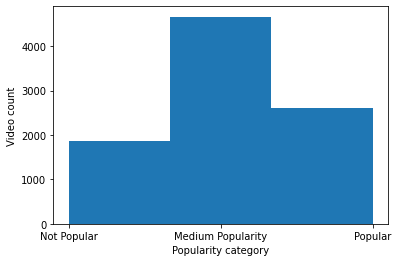

In [5]:
y.hist(bins=3, grid=False)
plt.xticks([1,2,3], labels=["Not Popular","Medium Popularity","Popular"])
plt.xlabel("Popularity category")
plt.ylabel("Video count")

### Combination plots
The diagrams below illustrate the relationship between the different features and the corresponding popularity category

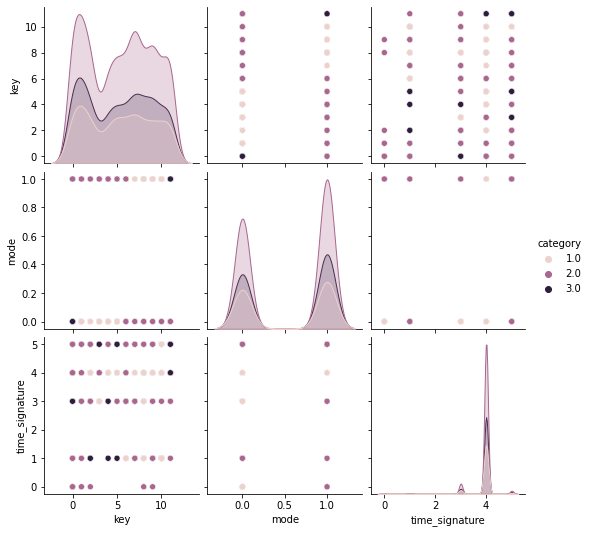

In [8]:
df['category'] = targets
categorical = ['key','mode','time_signature','category']
sns.pairplot(df[views > 0][categorical],hue='category')

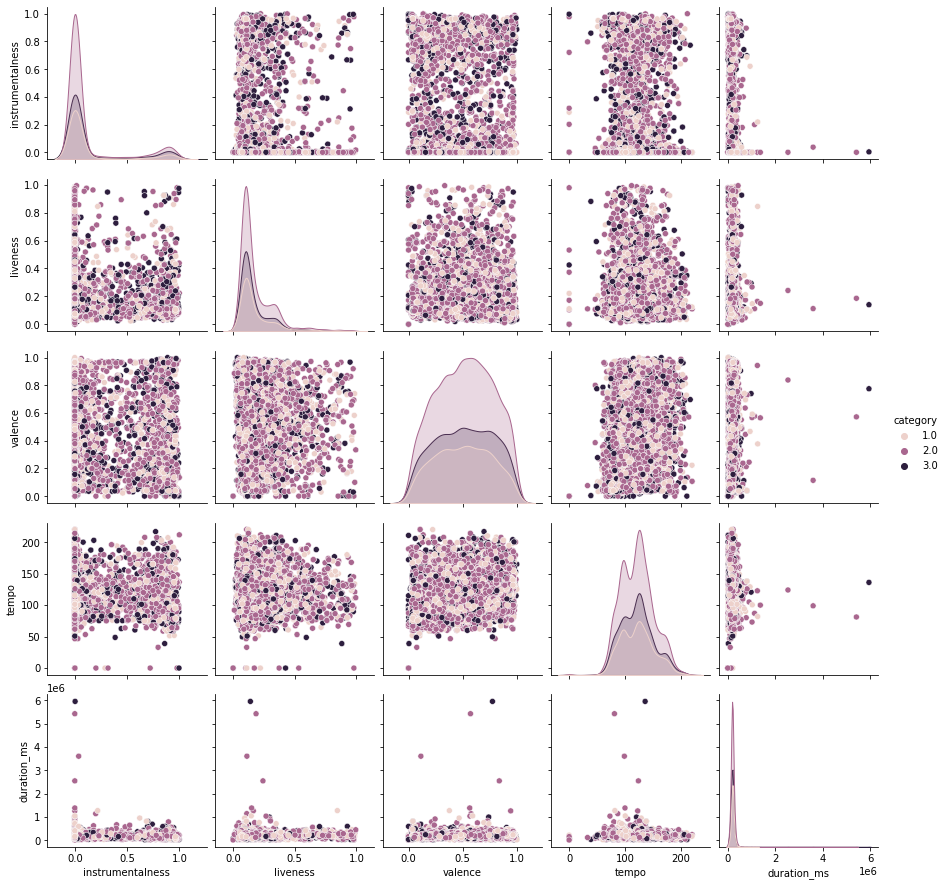

In [18]:
continuous = [
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'category'
]
sns.pairplot(df[views > 0][continuous],hue='category')

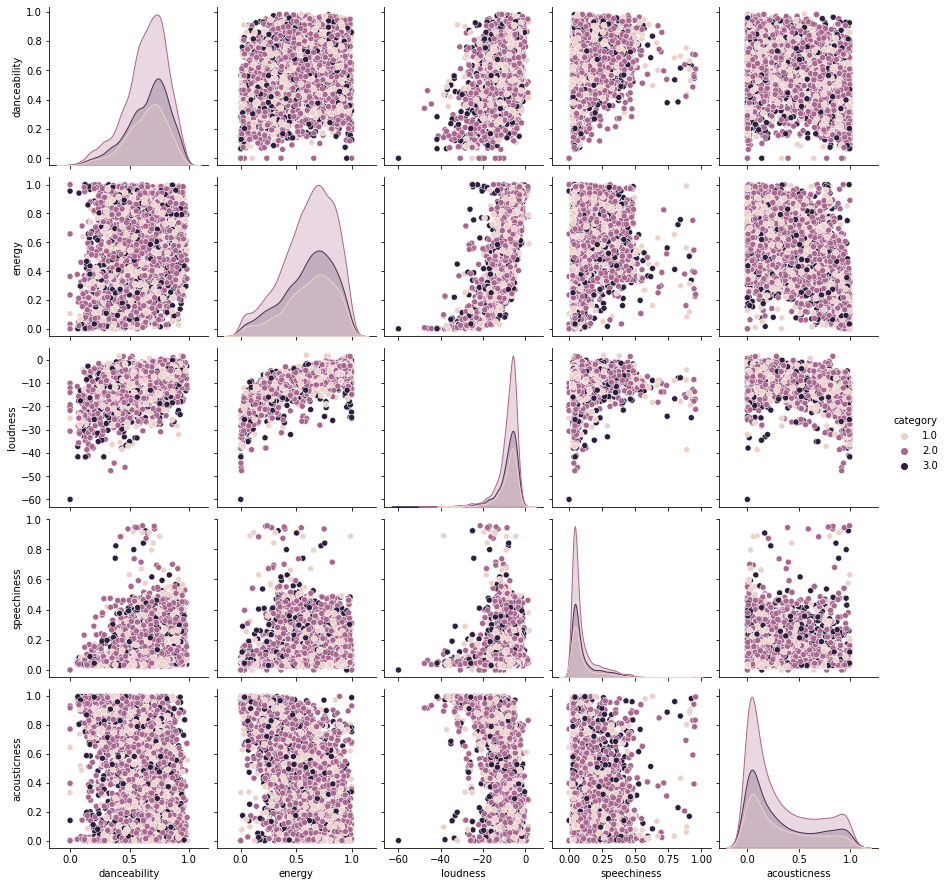

In [20]:
continuous = [
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'category'
]
sns.pairplot(df[views > 0][continuous],hue='category')

### Model training
Different classification models are trained and evaluated, and the minority classes are oversampled using ADASYN

In [15]:
models = [
    ("Baseline",dummy.DummyClassifier(strategy='stratified')),
    ("5-KNN",neighbors.KNeighborsClassifier(n_neighbors=5)),
    ("10-KNN",neighbors.KNeighborsClassifier(n_neighbors=10)),
    ("SVM Linear", svm.SVC(kernel='linear')),
    ("SVM RBF", svm.SVC(kernel='rbf')),
    ("Random Forest",ensemble.RandomForestClassifier()),
    ("Logistic Regression",linear_model.LogisticRegression())
]
oversampled_models = []
for name, model in models:
    combined = make_pipeline(
        ADASYN(),
        model
    )
    oversampled_models.append((name,combined))
    
metrics = {
    'precision': make_scorer(precision_score,average='macro',zero_division=0),
    'recall': 'recall_macro',
    'f1': 'f1_macro'
}
compare_models(oversampled_models,metrics, data, targets)

Evaluating Baseline
Evaluating 5-KNN
Evaluating 10-KNN
Evaluating SVM Linear
Evaluating SVM RBF
Evaluating Random Forest
Evaluating Logistic Regression


,model,fit_time,score_time,test_precision,test_recall,test_f1
0,Baseline,0.674862,0.004656,0.333142,0.333423,0.318700
1,5-KNN,0.703031,0.386974,0.356619,0.359063,0.333894
2,10-KNN,0.700539,0.434314,0.350810,0.354465,0.321153
3,SVM Linear,10.051612,0.458228,0.277785,0.347218,0.210919
4,SVM RBF,8.598828,1.968540,0.348715,0.351784,0.315012
5,Random Forest,3.780516,0.063674,0.351799,0.351019,0.350762
6,Logistic Regression,0.746090,0.004572,0.344641,0.347923,0.289855


The most promising model in terms of precision and recall is the KNN classifier. Using a confusion matrix will provide more insight into the performance of the model.

In [21]:
X_train, X_test, y_train,y_test = train_test_split(data, targets)
X_train, y_train = ADASYN().fit_resample(X_train,y_train)
model = neighbors.KNeighborsClassifier(5)
model.fit(X_train,y_train)
predicted = model.predict(X_test)

c:\users\georg\documents\msc-project\venv\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


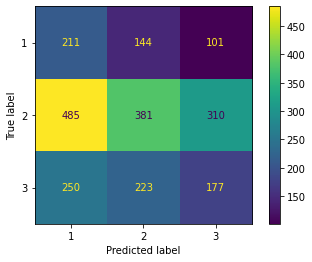

In [22]:
ConfusionMatrixDisplay.from_predictions(y_test,predicted)

Next, different values for K will be tried, in order to optimize for different metrics

In [23]:
prec, recall, f1 = [],[],[]
k_values = [5,10,15,20]
for k in k_values:
    model = make_pipeline(
        ADASYN(),
        neighbors.KNeighborsClassifier(k)
    )
    scores = evaluate_model(model,metrics, data,targets)
    prec.append(scores['test_precision'].mean())
    recall.append(scores['test_recall'].mean())
    f1.append(scores['test_f1'].mean())

Text(0.5, 0, 'K Value')

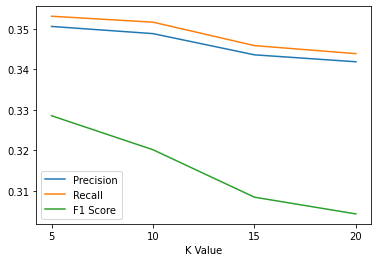

In [28]:
plt.xticks(k_values)
plt.plot(k_values,prec,label="Precision")
plt.plot(k_values,recall,label="Recall")
plt.plot(k_values,f1,label="F1 Score")
plt.legend()
plt.xlabel("K Value")